# Commuted Piano Dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## recreate the commuted piano sound from commuted_piano_bcruz_2025-02-20.ipynb


{'channel': 'L',
 'freq': 246.94165062806206,
 'hammer_delay_ms': 10.0,
 'ir_params': {'dry_wet_balance': 1.0,
               'fade_in_seconds': 0.0,
               'fade_out_seconds': 1.0,
               'length_seconds': 0.5668934240362812,
               'start_seconds': 0.0,
               'url': 'https://oramics.github.io/sampled/IR/EMT140-Plate/samples/emt_140_dark_1.wav'},
 'sample_rate': 44100,
 'strike_num_samples': 100,
 'strike_params_list': [{'left': -1.0, 'right': 10.0},
                        {'left': -1.1, 'right': 2.5},
                        {'left': -1.15, 'right': 0.0}],
 'strings': [{'ap_denom': [7.0, 1.0, 6.0],
              'feedback_gain': 0.995,
              'freq_ratio': 1.0,
              'gain': 0.5,
              'lpf_params': {'freq': 17000.0, 'q': 0.5}},
             {'ap_denom': [7.0, 1.0, 6.0],
              'feedback_gain': 0.99,
              'freq_ratio': 0.9999,
              'gain': 0.2,
              'lpf_params': {'freq': 17000.0, 'q': 0.5}},
 

/Users/briancruz/repos/research/music_299_2025sp/audio_utils.py:22: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _sr, plate = wavfile.read(download_url(url))


white_noise ['balanced-shiraz', 'broad-community', 'linear-mask']
white_noise


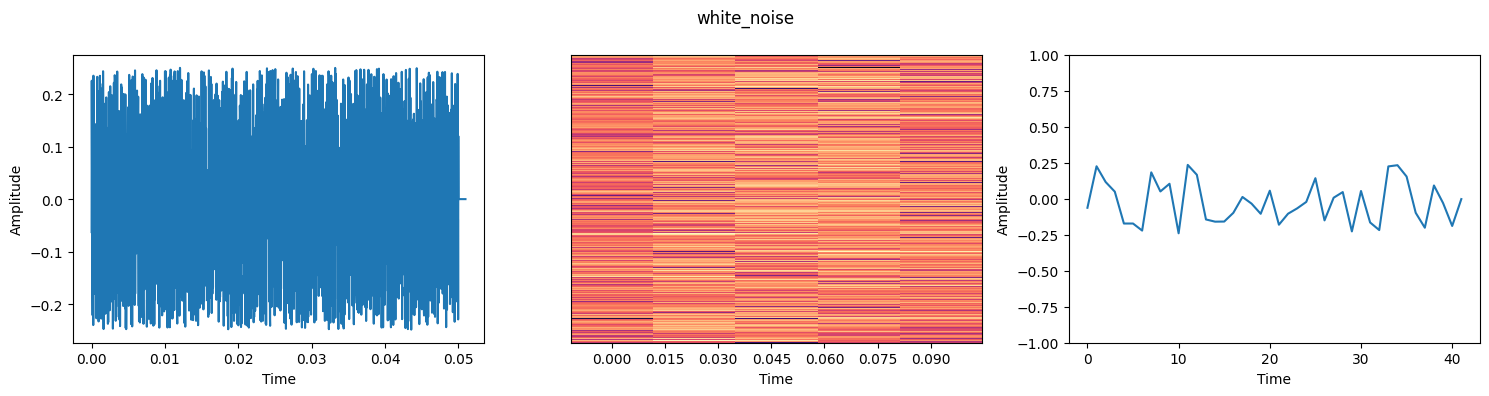

many filters ['watery-pressure', 'ambitious-photon', 'greasy-page']
many filters


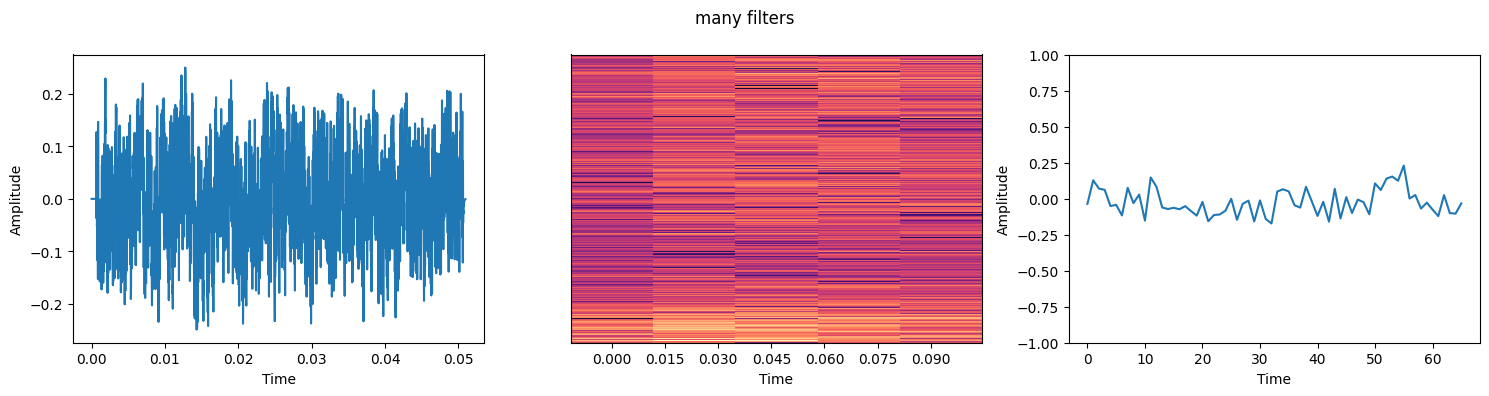

strike ['vibrato-patio', 'mashed-book', 'bipartite-sump']
strike


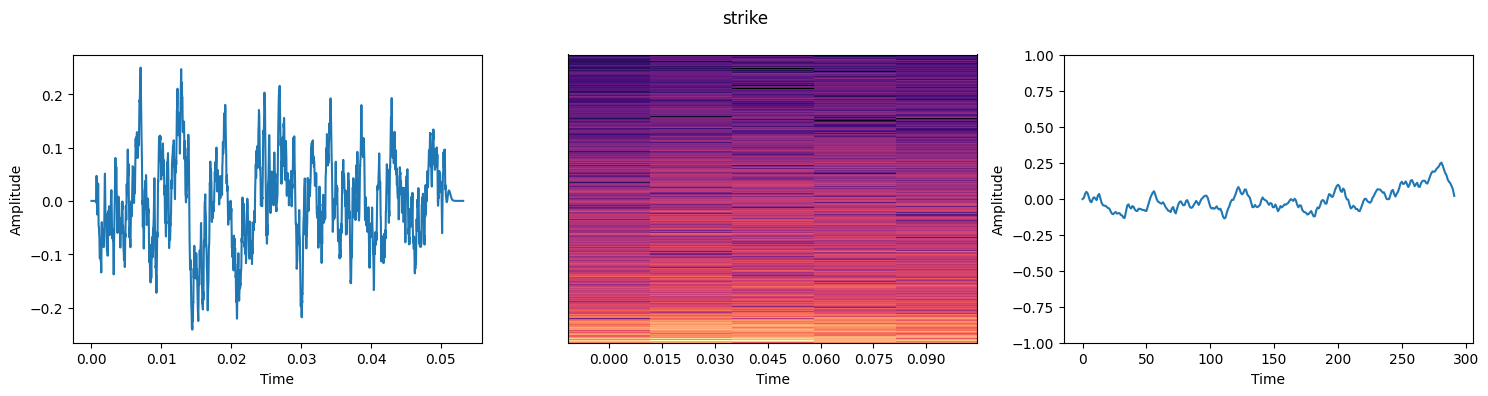

plate ['naive-line', 'descriptive-parameter', 'scared-contract']
plate


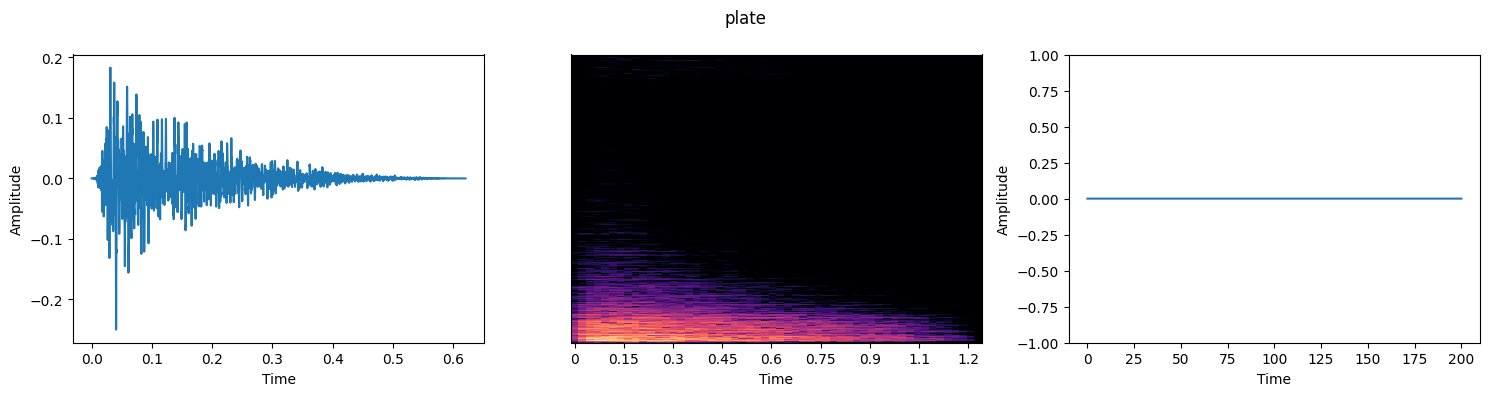

string ['upbeat-corona', 'frosty-draft', 'smoky-golf']
string


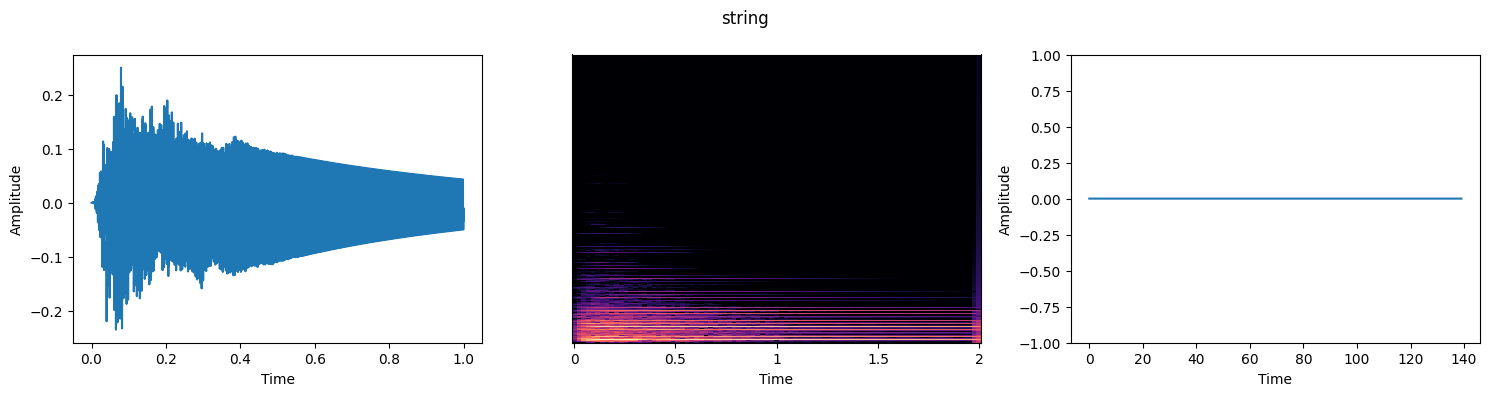

final ['upbeat-corona', 'frosty-draft', 'smoky-golf']
final


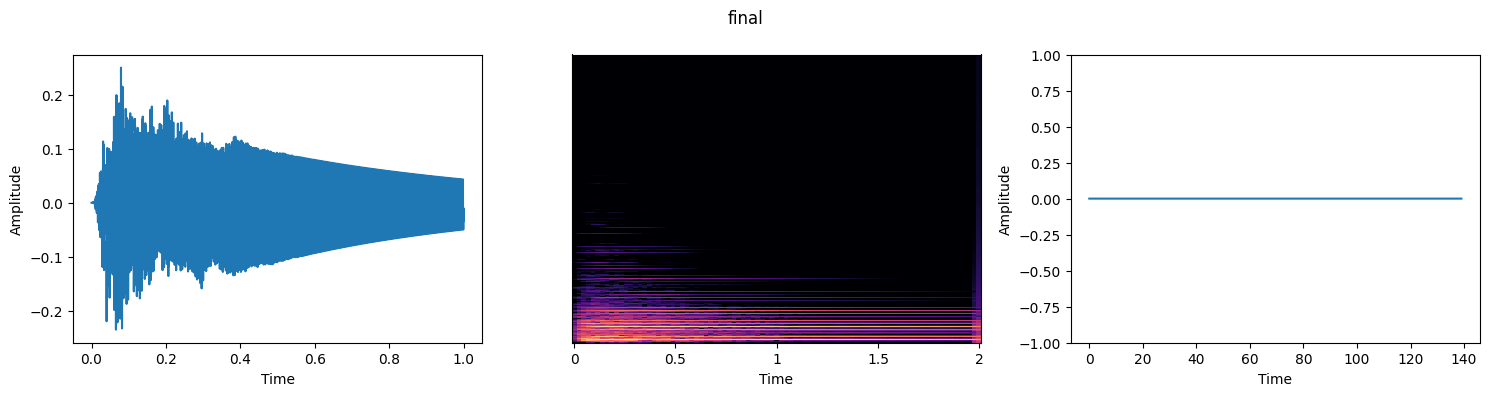

array([ 0.01101439,  0.01250019,  0.01332723, ..., -0.00940124,
       -0.00948532, -0.00951106])

In [2]:
from commuted_piano import CommutedPianoParams, params_to_piano_note, mtof
from audio_utils import play_audio
import pprint


note_params = CommutedPianoParams.model_validate(
    {
        "channel": "L",
        "freq": mtof(59),
        "hammer_delay_ms": 10.0,
        "sample_rate": 44100,
        "strike_num_samples": 100,
        "strike_params_list": [
            {"left": -1, "right": 10},
            {"left": -1.1, "right": 2.5},
            {"left": -1.15, "right": 0},
        ],
        "strings": [
            {
                "ap_denom": (ap_denom := [7.0, 1.0, 6.0]),
                "feedback_gain": 0.995,
                "freq_ratio": 1.0,
                "gain": 0.5,
                "lpf_params": {"freq": 17000.0, "q": 0.5},
            },
            {
                "ap_denom": ap_denom,
                "feedback_gain": 0.99,
                "freq_ratio": 0.9999,
                "gain": 0.2,
                "lpf_params": {"freq": 17000.0, "q": 0.5},
            },
            {
                "ap_denom": ap_denom,
                "feedback_gain": 0.999,
                "freq_ratio": 10.0,
                "gain": 0.1,
                "lpf_params": {"freq": 17000.0, "q": 0.5},
            },
        ],
        "ir_params": {
            "start_seconds": 0.000,
            "length_seconds": 25000.0 / 44100,
            "fade_in_seconds": 0.000,
            "fade_out_seconds": 1.0,
            "url": "https://oramics.github.io/sampled/IR/EMT140-Plate/samples/emt_140_dark_1.wav",
            "dry_wet_balance": 1.0,
        },
    }
)

pprint.pprint(note_params.model_dump())
note_params.to_piano_note(show_graphs=True)


## Create a pytorch dataset

This dataset will create random models with a set of parameters and the corresponding audio files. There are 38 parameters, which are uniformly sampled from \[0,1\) and then scaled accordingly. If the ranges are not chosen properly the synthesizer may run into instability issues.

In [3]:
from torch.utils.data import Dataset


class CommutedPianoDataset(Dataset):
    NUM_PARAMS = 38
    SAMPLE_RATE = 44100

    def __init__(self, train=True):
        self.train = train

    def __len__(self):
        if self.train:
            return 1000
        else:
            return 100

    def __getitem__(self, idx):
        import numpy as np

        r, sound = self.get_vec_and_sound(idx)

        # set sound to the first second
        sound = sound[: self.SAMPLE_RATE]
        # If less than a second, pad with zeros
        if len(sound) < self.SAMPLE_RATE:
            sound = np.pad(sound, (0, self.SAMPLE_RATE - len(sound)), "constant")

        mfcc = self.sound_to_mfcc(sound)

        mfcc = mfcc.flatten()

        r = np.array(r, dtype=np.float32)
        mfcc = np.array(mfcc, dtype=np.float32)

        # reverse since we want to predict the parameters
        return mfcc, r

    def get_vec_and_sound(self, idx):
        import numpy as np

        if self.train:
            rng = np.random.default_rng(seed=idx)
        else:
            rng = np.random.default_rng(seed=idx + 2**30)
        r = rng.uniform(0, 1, size=(self.NUM_PARAMS,))
        sound = self.parameter_vec_to_sound(r)
        return sound

    @classmethod
    def sound_to_mfcc(cls, sound):
        import librosa

        return librosa.feature.mfcc(y=sound, sr=cls.SAMPLE_RATE)

    @classmethod
    def parameter_vec_to_sound(cls, r):
        def scale(r, low, high):
            return r * (high - low) + low

        idx = -1

        def next_r(low, high):
            nonlocal idx
            idx += 1
            return scale(r[idx], low, high)

        note_params = CommutedPianoParams.model_validate(
            {
                "channel": "L",
                "freq": next_r(440, 880),
                "hammer_delay_ms": next_r(0.01, 10),
                "sample_rate": 44100,
                "strike_num_samples": int(next_r(10, 100)),
                "strike_params_list": [
                    {"left": next_r(-1, -1.1), "right": next_r(8, 12)},
                    {"left": next_r(-1.1, -1.15), "right": next_r(2, 3)},
                    {"left": next_r(-1.15, -1.3), "right": next_r(0, 1)},
                ],
                "strings": [
                    {
                        "ap_denom": (
                            ap_denom := [
                                (a := next_r(2, 10)),
                                next_r(0.1, 1.0),
                                a - next_r(0, 1),
                            ]
                        ),
                        "feedback_gain": next_r(0.95, 0.999),
                        "freq_ratio": (freq := next_r(0.95, 1.05)),
                        "gain": next_r(0.1, 0.9),
                        "lpf_params": {
                            "freq": next_r(10000, 22050),
                            "q": next_r(0.4, 0.7),
                        },
                    },
                    {
                        "ap_denom": ap_denom,
                        "feedback_gain": next_r(0.95, 0.999),
                        "freq_ratio": freq * next_r(0.999, 1.001),
                        "gain": next_r(0.1, 0.9),
                        "lpf_params": {
                            "freq": next_r(10000, 22050),
                            "q": next_r(0.4, 0.7),
                        },
                    },
                    {
                        "ap_denom": ap_denom,
                        "feedback_gain": next_r(0.95, 0.999),
                        "freq_ratio": next_r(5, 15),
                        "gain": next_r(0.1, 0.9),
                        "lpf_params": {
                            "freq": next_r(10000, 22050),
                            "q": next_r(0.4, 0.7),
                        },
                    },
                ],
                "ir_params": {
                    "start_seconds": next_r(0.0, 0.1),
                    "length_seconds": next_r(0.3, 2.0),
                    "fade_in_seconds": next_r(0.0, 0.001),
                    "fade_out_seconds": next_r(0.3, 2.0),
                    "url": "https://oramics.github.io/sampled/IR/EMT140-Plate/samples/emt_140_dark_1.wav",
                    "dry_wet_balance": next_r(0.0, 1.0),
                },
            }
        )
        sound = note_params.to_piano_note()
        return r, sound

[0.63696169 0.26978671 0.04097352 0.01652764 0.81327024 0.91275558
 0.60663578 0.72949656 0.54362499 0.93507242 0.81585355 0.0027385
 0.85740428 0.03358558 0.72965545 0.17565562 0.86317892 0.54146122
 0.29971189 0.42268722 0.02831967 0.12428328 0.67062441 0.64718951
 0.61538511 0.38367755 0.99720994 0.98083534 0.68554198 0.65045928
 0.68844673 0.38892142 0.13509651 0.72148834 0.52535432 0.31024188
 0.48583536 0.88948783]


/Users/briancruz/repos/research/music_299_2025sp/audio_utils.py:22: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _sr, plate = wavfile.read(download_url(url))


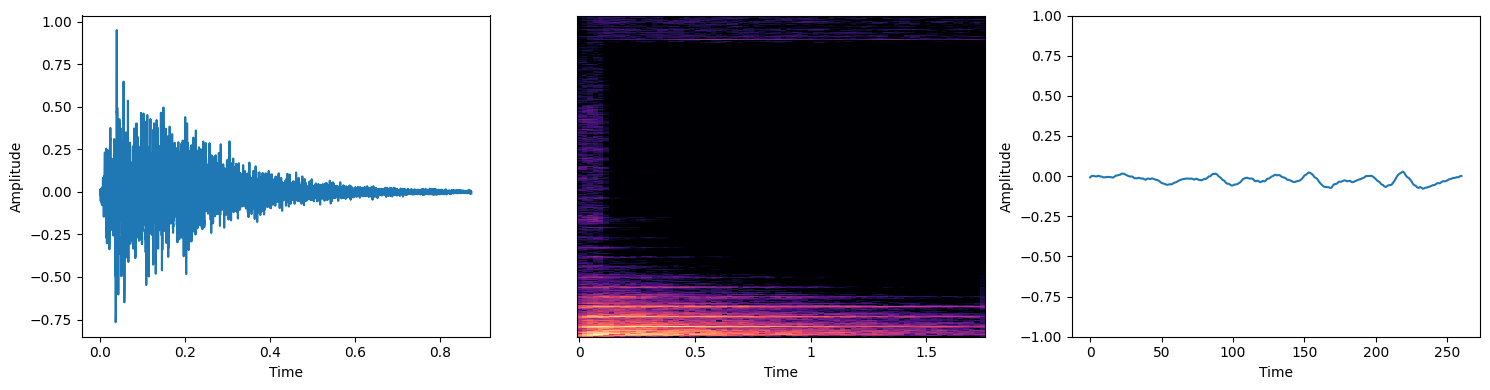

[0.51182162 0.9504637  0.14415961 0.94864945 0.31183145 0.42332645
 0.82770259 0.40919914 0.54959369 0.02755911 0.75351311 0.53814331
 0.32973172 0.7884287  0.30319483 0.45349789 0.1340417  0.40311299
 0.20345524 0.26231334 0.75036467 0.28040876 0.48519097 0.9807372
 0.96165719 0.72478994 0.54122686 0.2768912  0.16065201 0.96992541
 0.51606859 0.11586561 0.62348976 0.77668311 0.6130033  0.9172977
 0.03959288 0.52858926]


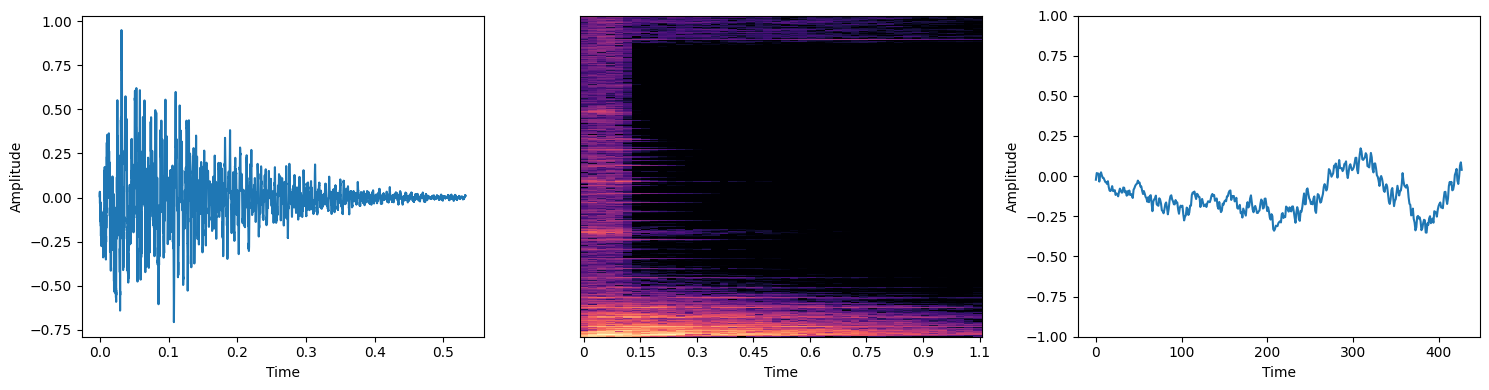

[0.26161213 0.29849114 0.81422574 0.09191594 0.60010053 0.72856053
 0.18790107 0.05514663 0.27496937 0.65743301 0.56226566 0.15006226
 0.43263079 0.6692973  0.42278467 0.6331844  0.96743595 0.68306482
 0.39162483 0.18725257 0.34596067 0.51106597 0.89120941 0.77556394
 0.3181466  0.9242169  0.47090989 0.69375884 0.10720731 0.10454356
 0.20190745 0.88444967 0.67981146 0.84923632 0.64443627 0.4065424
 0.51657819 0.59344352]


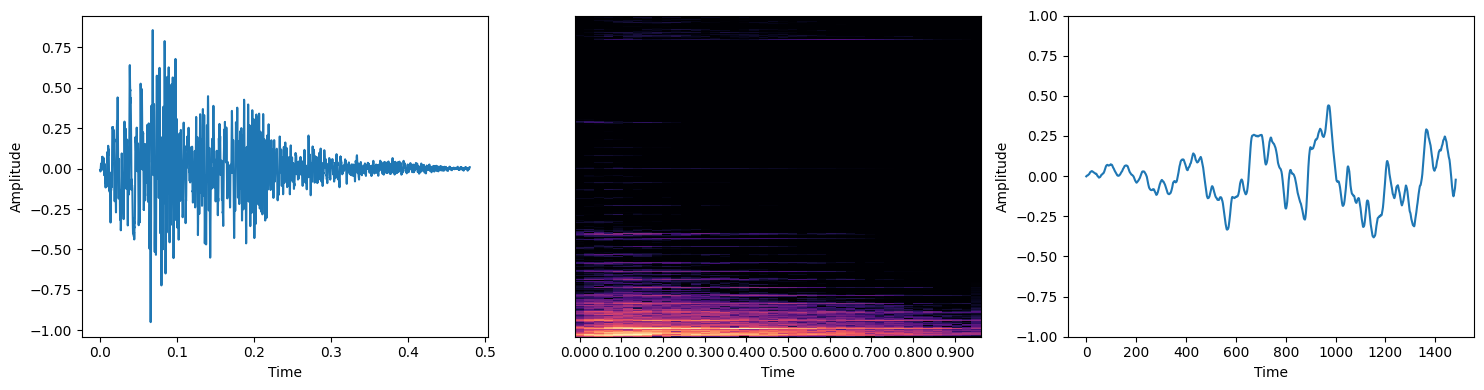

[0.08564917 0.23681051 0.80127447 0.58216204 0.09412864 0.43312694
 0.4790513  0.15973891 0.73457715 0.11367202 0.39122819 0.51674018
 0.43062802 0.58679857 0.73783779 0.95626725 0.28420116 0.64854721
 0.696216   0.29272075 0.00149008 0.97346027 0.29840122 0.313986
 0.89171107 0.58516294 0.47130967 0.77327701 0.03034601 0.7069651
 0.37424383 0.09085271 0.66050007 0.93146385 0.20719117 0.6300902
 0.29816309 0.74175668]


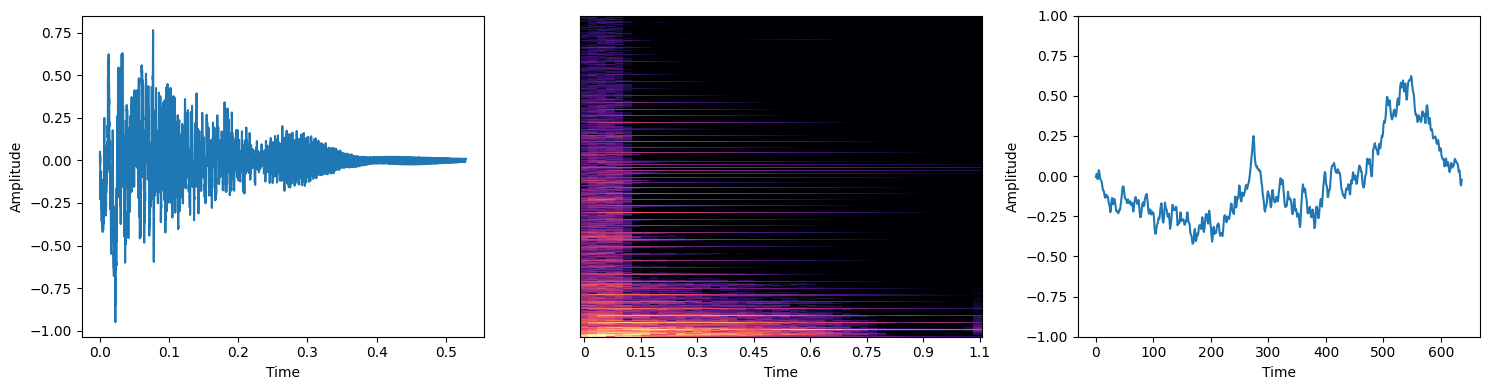

[0.94305611 0.51132755 0.97624371 0.08083602 0.60735583 0.37648658
 0.80190121 0.17452782 0.87163527 0.5439414  0.90221508 0.47715352
 0.43049628 0.78894672 0.984153   0.36972579 0.96893287 0.92902639
 0.17769259 0.60885162 0.70486475 0.94280368 0.66565742 0.13339576
 0.4978676  0.49361983 0.50022619 0.95858229 0.3499374  0.22377115
 0.522087   0.64117092 0.93910705 0.5820158  0.26783339 0.9297747
 0.49172528 0.67580086]


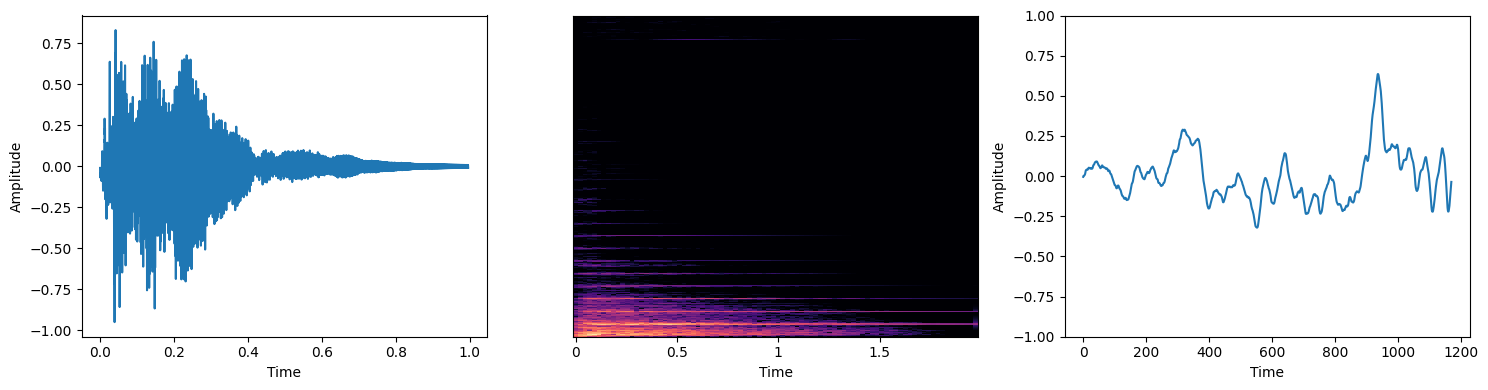

[0.80500292 0.80794079 0.51532556 0.28580138 0.0539307  0.38336888
 0.40847321 0.04527519 0.04875771 0.99917612 0.65236911 0.2345102
 0.43494755 0.97418619 0.89767761 0.84423104 0.39240466 0.49302302
 0.67668935 0.06080271 0.55559612 0.2714516  0.87965117 0.06421444
 0.67918153 0.8700885  0.22731853 0.89544824 0.87219547 0.01851722
 0.70749557 0.00119968 0.50336397 0.43666705 0.20325284 0.32494264
 0.80621533 0.31645209]


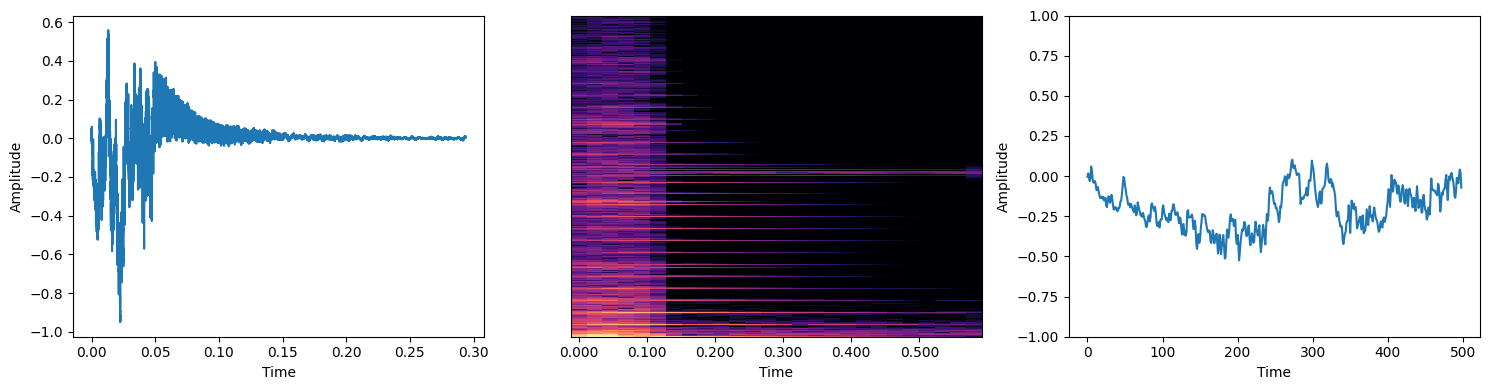

[0.53816435 0.34327087 0.36906724 0.37449677 0.98744499 0.63275627
 0.67432393 0.32996346 0.67991766 0.12297237 0.05172923 0.85019135
 0.00889581 0.97876756 0.82700303 0.78521096 0.04808349 0.20743927
 0.84986563 0.43249481 0.62746793 0.1222824  0.18633632 0.49726791
 0.75946658 0.5398572  0.10688008 0.86618608 0.13965891 0.43965776
 0.58684947 0.3191495  0.41805417 0.88696449 0.4541357  0.53924711
 0.97048915 0.27598314]


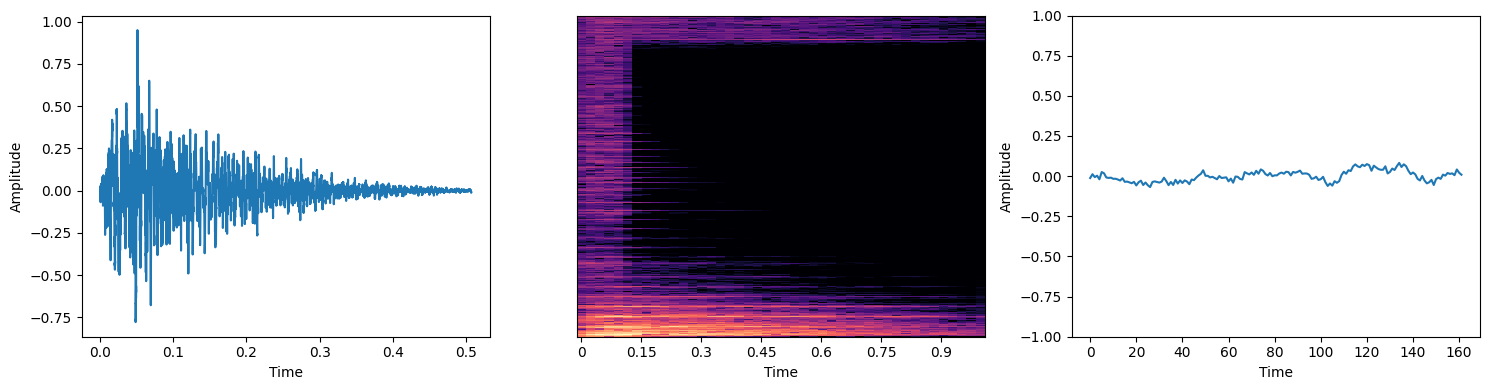

[0.62509547 0.8972138  0.77568569 0.22520719 0.30016628 0.87355345
 0.0052653  0.82122842 0.79706943 0.46793495 0.30303243 0.27842561
 0.25486959 0.44507631 0.50454826 0.55349735 0.99550028 0.79266192
 0.62217923 0.98896015 0.2153087  0.16021203 0.6125396  0.04394201
 0.03568028 0.51488882 0.46620603 0.91716777 0.62922625 0.51411765
 0.49687344 0.24751492 0.01179403 0.19240214 0.69203212 0.20060672
 0.36953631 0.00373424]


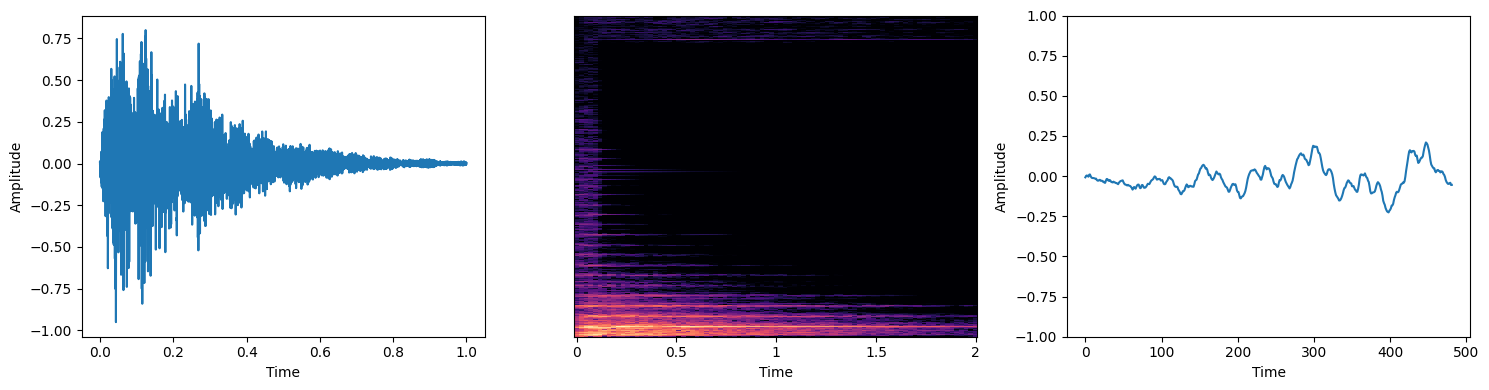

[0.32697228 0.98727684 0.31871084 0.78854894 0.86989651 0.39108481
 0.43788187 0.3727489  0.1069536  0.47896545 0.24135215 0.25714525
 0.18473156 0.19386455 0.81382767 0.42298419 0.25592051 0.59090285
 0.6042723  0.64685803 0.91135638 0.15020611 0.37138713 0.28462064
 0.01678205 0.18155394 0.39466858 0.39331071 0.61672794 0.45226653
 0.60733067 0.22305999 0.13398713 0.32928938 0.09610843 0.36583991
 0.46017931 0.71898864]


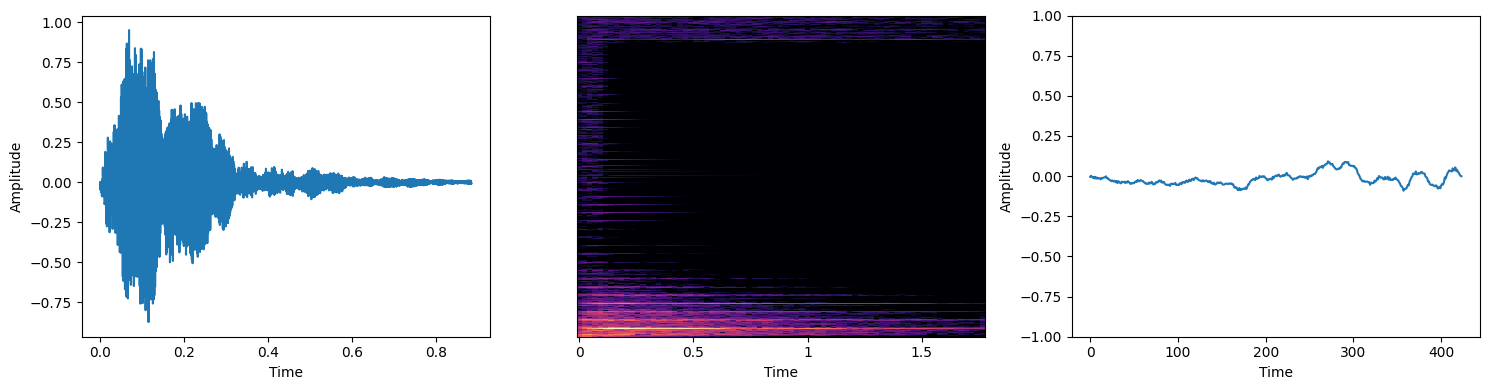

[0.8702492  0.28681721 0.60314815 0.77753408 0.71607463 0.91538012
 0.86039365 0.91823763 0.02658773 0.437248   0.48494433 0.0651542
 0.00562605 0.83062144 0.98330224 0.78460985 0.31560349 0.7053337
 0.29918107 0.74074848 0.27974722 0.78259092 0.98774075 0.98623855
 0.88286257 0.91281005 0.70820691 0.55449688 0.92323821 0.08973078
 0.37013155 0.60593894 0.4777299  0.79285788 0.19508639 0.0622535
 0.12651841 0.96278158]


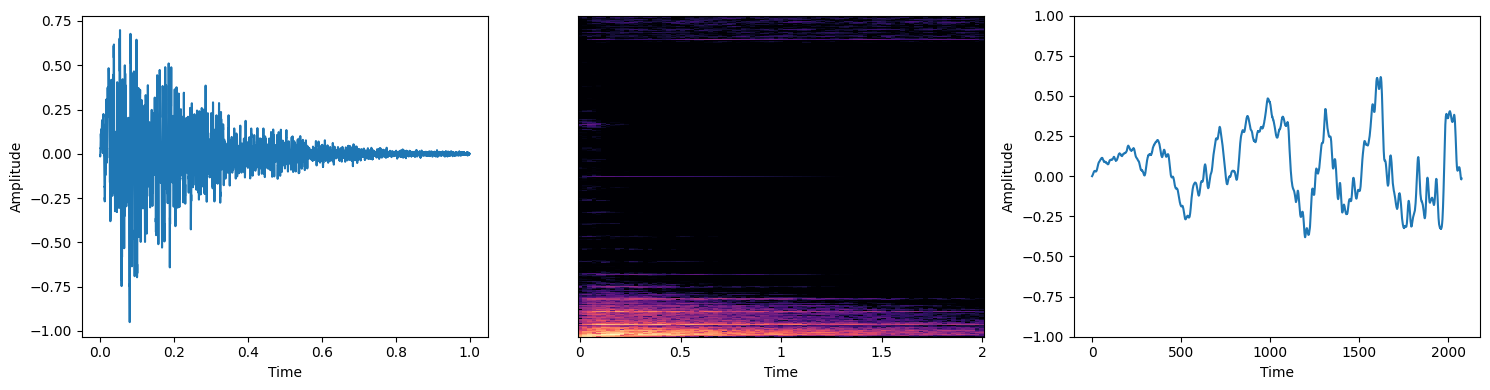

In [4]:
# Show some examples
ds = CommutedPianoDataset(train=True)
for i in range(10):
    params, sound = ds.get_vec_and_sound(i)
    print(params)
    play_audio(sound)


# Train a simple model

In [5]:
vec, mfcc = ds[1]
print(vec.shape, mfcc.shape)

(1740,) (38,)


In [6]:
# Train a regression model

import torch
import torch.nn as nn
import torch.optim as optim


# use the mac shaders
device = torch.device("mps")


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1740, 11000)
        self.fc2 = nn.Linear(11000, 15000)
        self.fc3 = nn.Linear(15000, 3000)
        self.fc4 = nn.Linear(3000, 38)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)

        return x


net = Net()

net = net.to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(
    net.parameters(),
    lr=0.0001,  # 0.001 ran into instabilities while training
    momentum=0.9,
)

trainloader = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=True)

for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 5 == 0:  # print every 5 mini-batches
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 5}")
            running_loss = 0.0

/Users/briancruz/repos/research/music_299_2025sp/audio_utils.py:22: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _sr, plate = wavfile.read(download_url(url))


[1, 1] loss: 3.4739593505859374
[1, 6] loss: 74.21363525390625
[1, 11] loss: 4.339004564285278
[1, 16] loss: 1.0557865977287293
[1, 21] loss: 0.3732999265193939
[1, 26] loss: 0.1658667027950287
[1, 31] loss: 0.12209622263908386
[2, 1] loss: 0.021715621650218963
[2, 6] loss: 0.10163107216358185
[2, 11] loss: 0.09268878251314164
[2, 16] loss: 0.0911772757768631
[2, 21] loss: 0.0852017804980278
[2, 26] loss: 0.08867330998182296
[2, 31] loss: 0.08678164780139923


In [10]:
# evaluate the model on the test set

ds_test = CommutedPianoDataset(train=False)
testloader = torch.utils.data.DataLoader(ds_test, batch_size=32, shuffle=True)


running_loss = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data

    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    running_loss += loss.item()

print(f"Test loss: {running_loss / len(testloader)}")

Test loss: 0.08370078727602959


# Let's see how good this is actually doing in terms of sound

/Users/briancruz/repos/research/music_299_2025sp/audio_utils.py:22: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _sr, plate = wavfile.read(download_url(url))


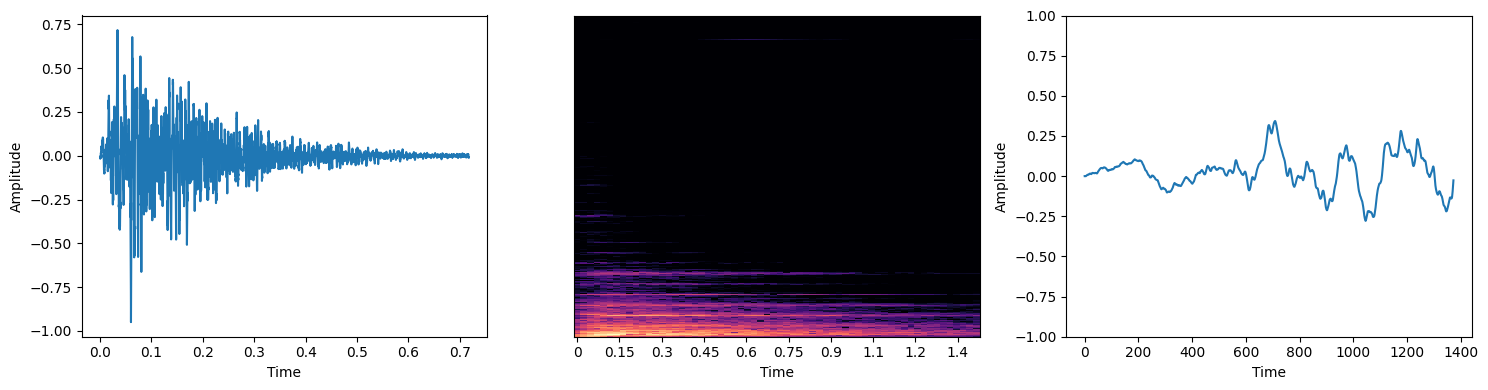

In [31]:
from audio_utils import play_audio

compare_index = 3

r, sound = ds_test.get_vec_and_sound(compare_index)
play_audio(sound, auto_play=True)


In [32]:
mfcc_values, original_params = ds_test[compare_index]
predicted_params = net(torch.Tensor(mfcc_values).to(device)).cpu().detach().numpy()
print(original_params)
print(predicted_params)

# Show the params that differ by more than 0.1
diff = abs((original_params - predicted_params) > 0.1)
print(diff)


[0.5978581  0.78112864 0.9210108  0.84777135 0.02393286 0.4111279
 0.12690327 0.6318243  0.45906755 0.9591643  0.78965443 0.998305
 0.31144026 0.9257961  0.63924026 0.65982217 0.20279229 0.32020178
 0.02972854 0.08263681 0.23386371 0.09184928 0.9997231  0.15665993
 0.9376113  0.51753485 0.5096215  0.7472016  0.4383107  0.7246673
 0.7977678  0.8201496  0.7992241  0.12130811 0.43657133 0.993142
 0.39969003 0.33073193]
[0.541142   0.47396696 0.4451942  0.47238323 0.60757226 0.47272068
 0.49649334 0.4875341  0.4196186  0.57884806 0.5116413  0.5656861
 0.5238759  0.7119664  0.61280745 0.5052519  0.475964   0.4753874
 0.5818546  0.55812955 0.5376038  0.46701893 0.59763366 0.4942841
 0.53745884 0.5279004  0.5827035  0.48814163 0.4913881  0.4643172
 0.62338024 0.55074304 0.5861277  0.553411   0.48383784 0.4291572
 0.5991231  0.41042536]
[False  True  True  True False False False  True False  True  True  True
 False  True False  True False False False False False False  True False
  True False 

/Users/briancruz/repos/research/music_299_2025sp/audio_utils.py:22: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _sr, plate = wavfile.read(download_url(url))


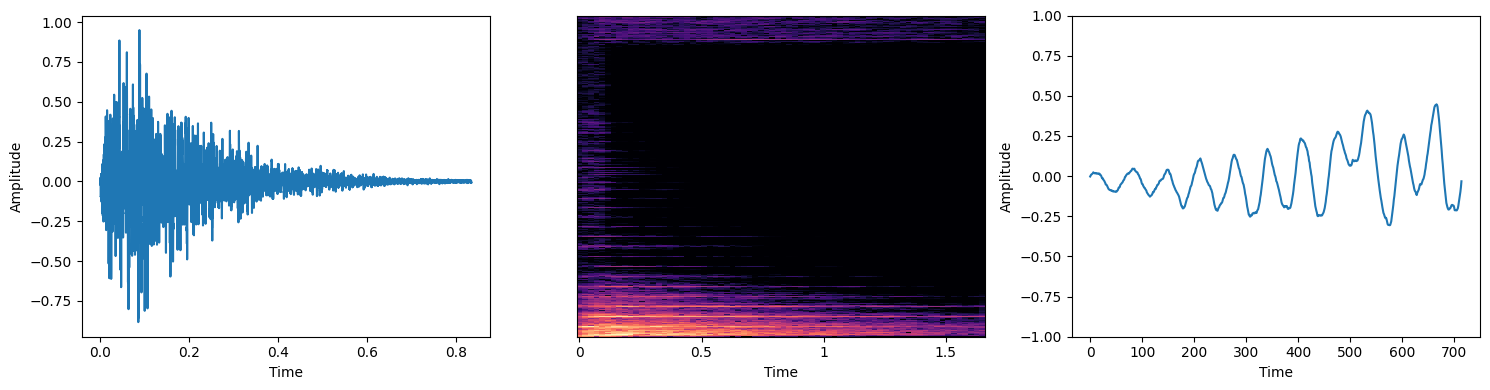

In [33]:
scaled_r, predicted_sound = CommutedPianoDataset.parameter_vec_to_sound(
    predicted_params
)

play_audio(predicted_sound, auto_play=True)

This doesn't really work, but it's a start. Let's start with fewer parameters, for instance fixing the frequency or at least limiting its range.